# Loan Default Risk Prediction

This notebook walks through:
- Dataset checks
- Data cleaning
- Exploratory data analysis
- Preprocessing and SMOTE
- Model training and evaluation
- Threshold tuning for RF
- Final predictions and model ingights

**Author**: Thomas Stone-Wigg

Import Python Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score, roc_auc_score
)

from imblearn.over_sampling import SMOTE


## 1. Load and Inspect Data
Load the Kaggle training dataset and display the first few rows to understand the structure.


In [52]:
# Load dataset
df = pd.read_csv('data/cs-training.csv', index_col=0)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 2. Run Initial Dataset Checks
This function identifies issues like duplicates, missing values, unnamed columns, invalid entries (e.g. age < 18), etc.


In [53]:
from check_dataset import check_dataset
summary = check_dataset(df)

# Show all duplicates (not just the first occurrence)
dupes = df[df.duplicated()]

# Sort by age or another feature for visual inspection
dupes_sorted = dupes.sort_values(by=df.columns.tolist())

# Show first 10 rows of potential duplicates
print(f"Found {dupes_sorted.shape[0]} potential duplicate rows.")
dupes_sorted.head(5)

Inspection Report for Dataset
--------------------------------------------------
✅ No unnamed columns.
❌ 609 duplicate rows found.
✅ No constant columns.
✅ No columns with >95% zeros.
✅ All columns are numeric.
⚠️ Missing values detected:
MonthlyIncome         29731
NumberOfDependents     3924
dtype: int64
❌ 1 rows with age < 18
--------------------------------------------------
Found 609 potential duplicate rows.


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
137103,0,0.0,21,0,0.0,0.0,1,0,0,0,0.0
83553,0,0.0,21,0,0.0,820.0,2,0,0,0,0.0
139346,0,0.0,21,0,0.0,820.0,2,0,0,0,0.0
127725,0,0.0,21,0,0.0,NaN,1,0,0,0,0.0
54654,0,0.0,22,0,0.0,0.0,1,0,0,0,0.0


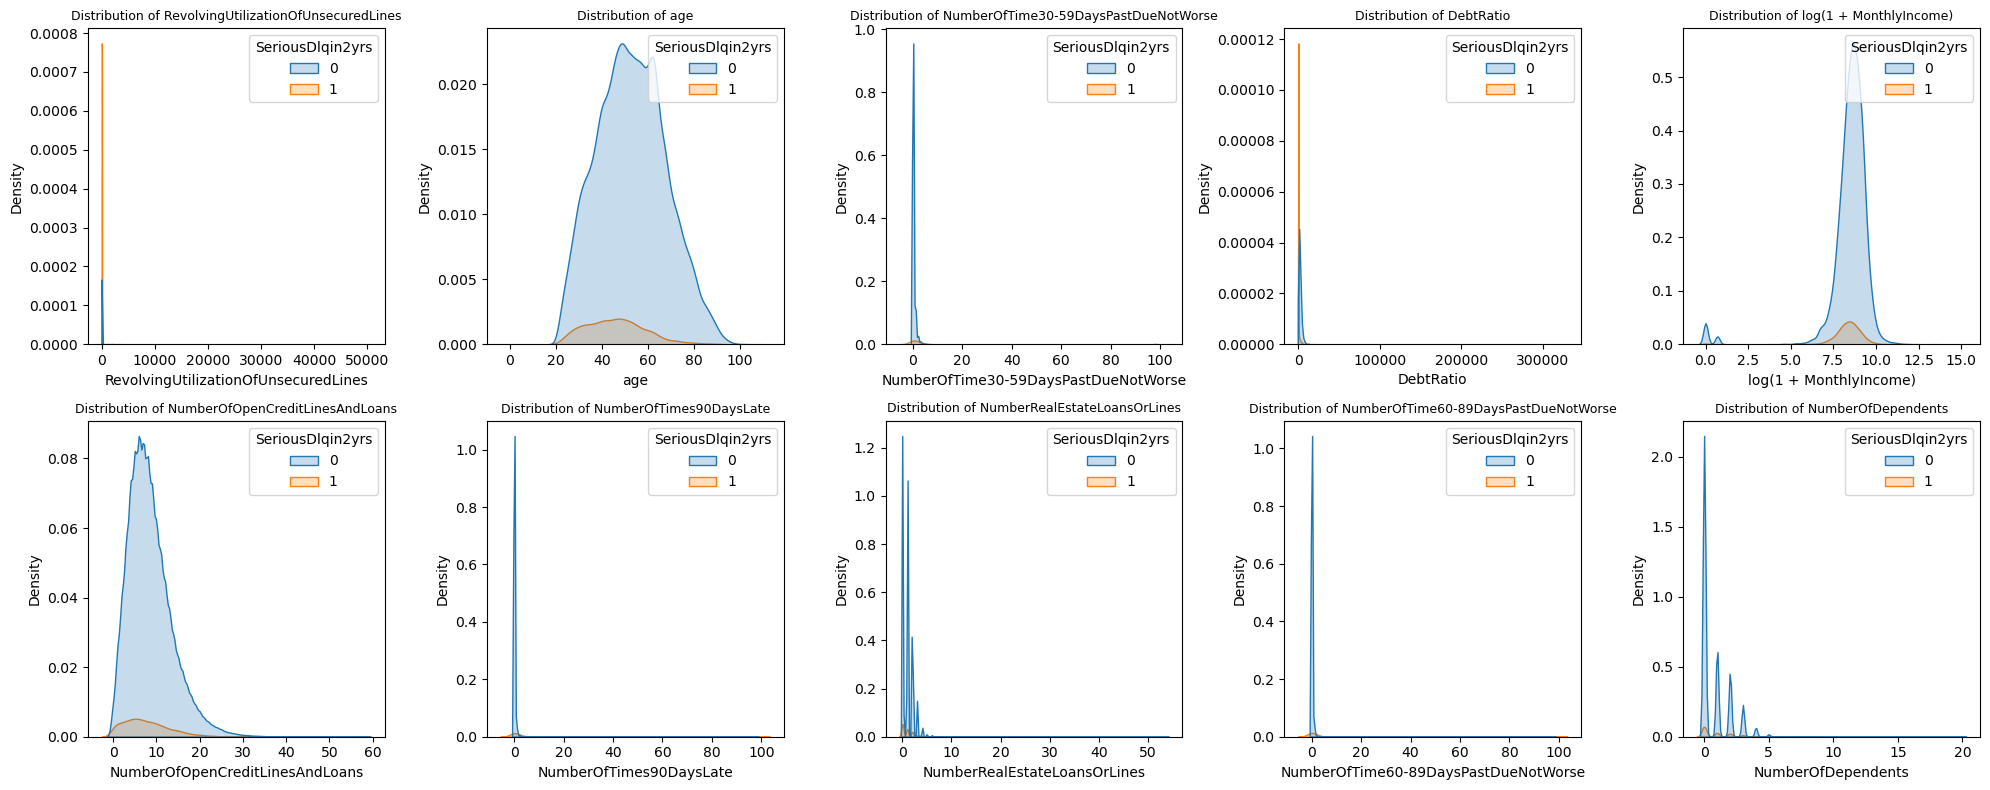

In [54]:
numerical_columns = [
    'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

# Set up grid
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(numerical_columns):
    data = np.log1p(df[col]) if col == 'MonthlyIncome' else df[col]
    xlabel = 'log(1 + MonthlyIncome)' if col == 'MonthlyIncome' else col

    sns.kdeplot(data=df, x=data, hue=df['SeriousDlqin2yrs'],
                fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {xlabel}', fontsize=9)
    axes[i].set_xlabel(xlabel)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

## 3. Clean the Data

Use a custom function, `clean_loan_data()`, to prepare the dataset for modeling:

1. **Remove duplicate rows**  
   Ensures no borrower is accidentally counted twice.

2. **Drop borrowers with invalid ages**  
   Removes records where age is below 18 (Could be caught by extreme outliers cap).

3. **Impute missing values**  
   - `MonthlyIncome` and `NumberOfDependents` are filled with their respective medians.  
   - Keeps the distribution realistic while avoiding deletion of valuable records.

4. **Cap extreme outliers**  
   - For each numeric column, values above the 99th percentile are clipped.  
   - This avoids extreme values from dominating the model (eg DebtRatio = 6000+).

This cleaning function ensures that:
- The model trains on realistic, structured data
- Retain as many valid records as possible without introducing bias
- Outliers and invalid entries don’t distort model behavior


In [55]:
from loan_data_cleaner import clean_loan_data

df_clean = clean_loan_data(df)
df_clean.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,4,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,23084.1,7,0,1,0,0.0


## 4. Rerun Dataset Checks
Recheck data set to make sure its cleaned sufficently.

In [56]:
check_dataset(df_clean)

dupes = df_clean[df_clean.duplicated()]
# dupes_sorted = dupes.sort_values(by='age')
dupes_sorted = dupes.sort_values(by=dupes.columns.tolist())
print(f"Found {dupes_sorted.shape[0]} potential duplicate rows.")
dupes_sorted.head(5)

Inspection Report for Dataset
--------------------------------------------------
✅ No unnamed columns.
❌ 216 duplicate rows found.
✅ No constant columns.
✅ No columns with >95% zeros.
✅ All columns are numeric.
✅ No missing values.
✅ All age values >= 18.
--------------------------------------------------
Found 216 potential duplicate rows.


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
100595,0,0.0,21,0,0.0,5400.0,1,0,0,0,0.0
115786,0,0.0,23,0,0.0,5400.0,1,0,0,0,0.0
59183,0,0.0,24,0,0.0,5400.0,1,0,0,0,0.0
117303,0,0.0,24,0,520.0,5400.0,3,0,0,0,0.0
18699,0,0.0,25,0,0.0,5400.0,1,0,0,0,0.0


## 5. EDA
Examine distributions of each feature, grouped by default status, to understand how features relate to risk.

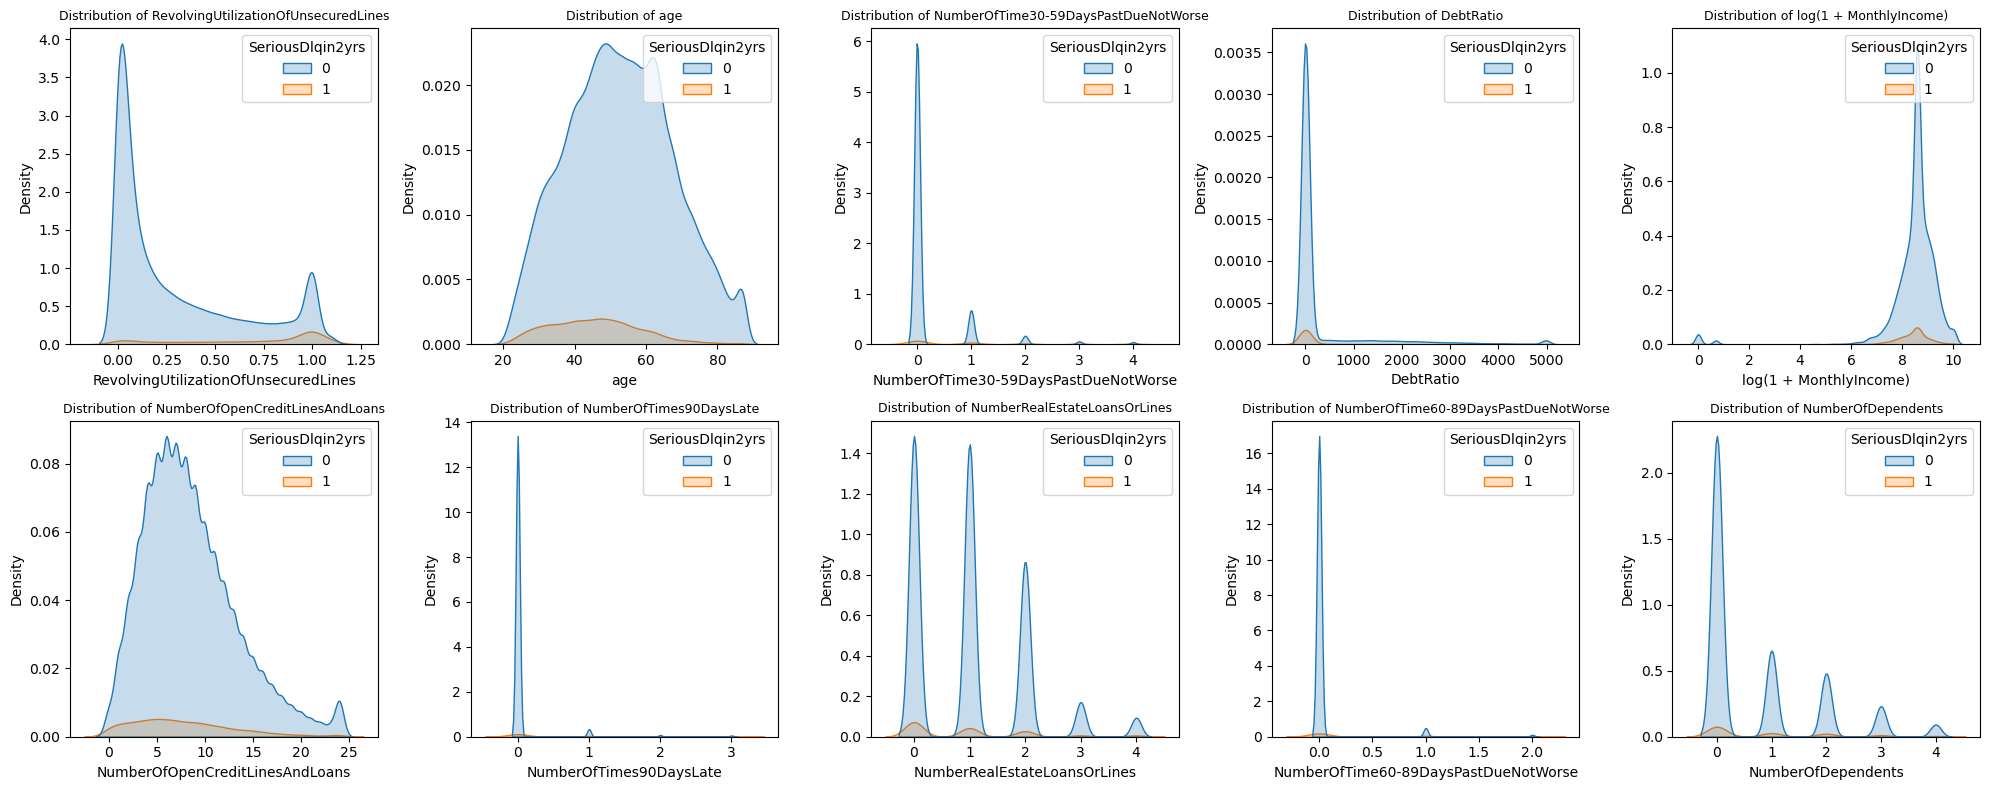

In [57]:
# Set up grid
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(numerical_columns):
    data = np.log1p(df_clean[col]) if col == 'MonthlyIncome' else df_clean[col]
    xlabel = 'log(1 + MonthlyIncome)' if col == 'MonthlyIncome' else col

    sns.kdeplot(data=df_clean, x=data, hue=df_clean['SeriousDlqin2yrs'],
                fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {xlabel}', fontsize=9)
    axes[i].set_xlabel(xlabel)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

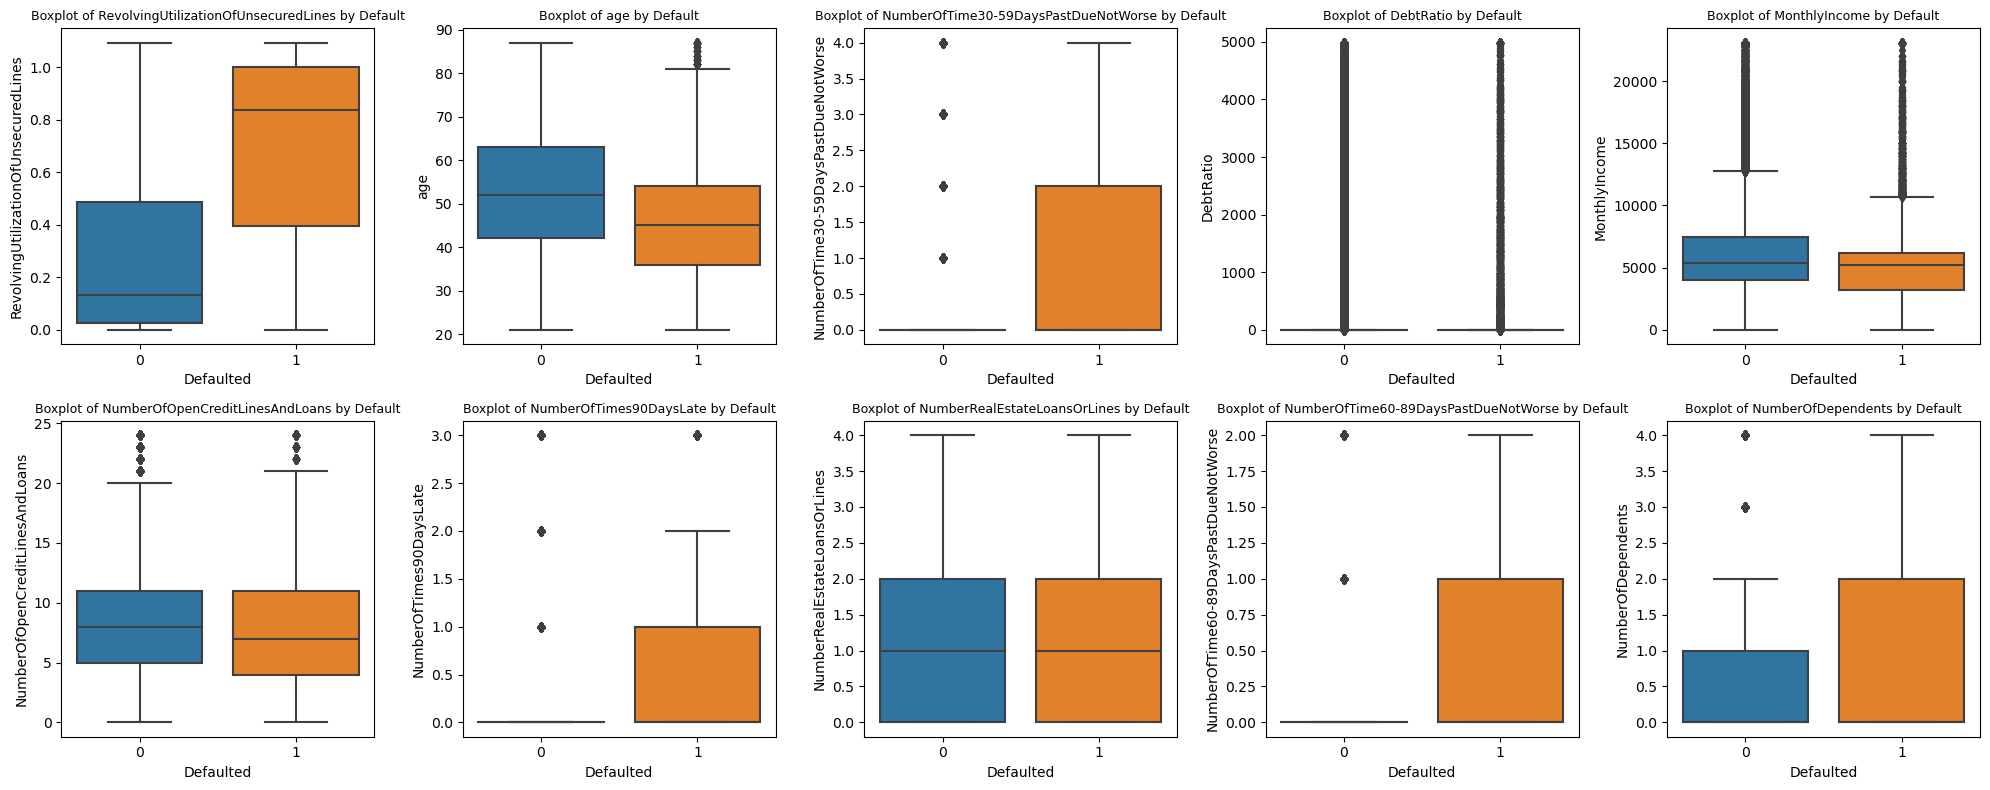

In [58]:
# Set up grid
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(numerical_columns):
    sns.boxplot(data=df_clean, x='SeriousDlqin2yrs', y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by Default', fontsize=9)
    axes[i].set_xlabel('Defaulted')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


Compute and visualise correlations with SeriousDqlin2yrs to show strong relationships:

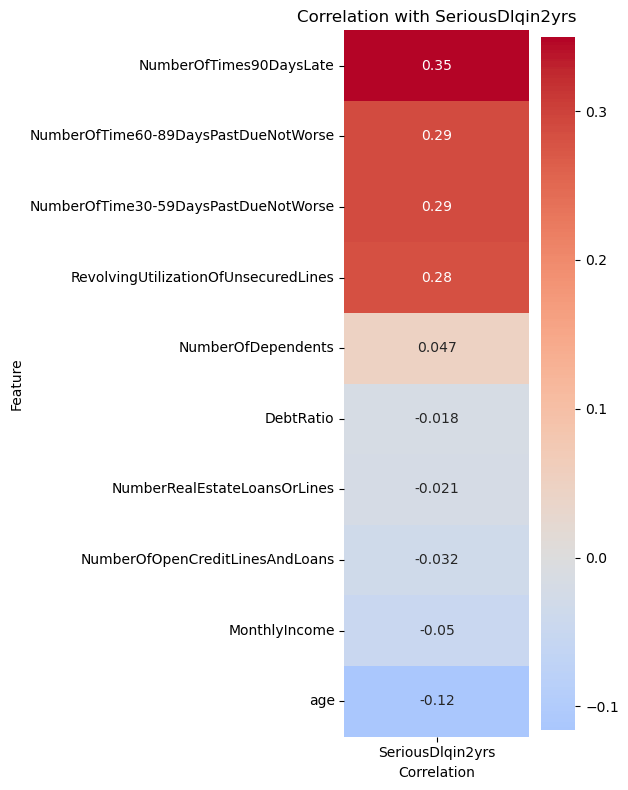

In [59]:
# Compute correlations with target
target_corr = df_clean.corr()['SeriousDlqin2yrs'].drop('SeriousDlqin2yrs')

# Sort by correlation strength
target_corr_sorted = target_corr.reindex(target_corr.sort_values(ascending=False).index)

# Plot vertical heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(target_corr_sorted.to_frame(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation with SeriousDlqin2yrs")
plt.ylabel("Feature")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()


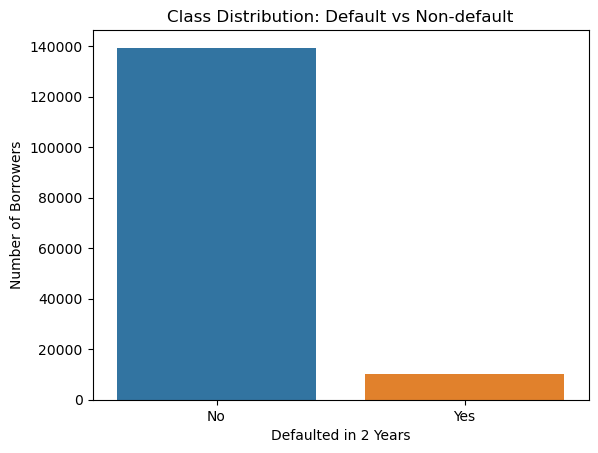

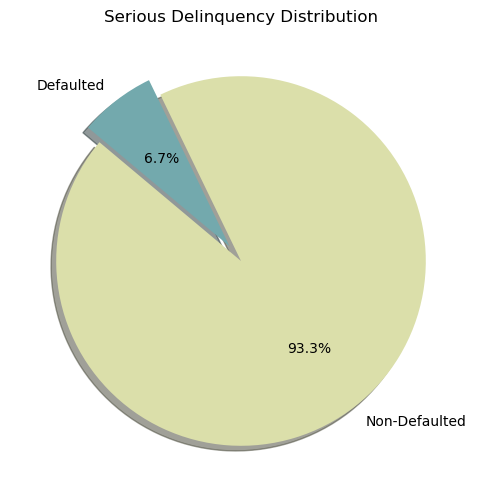

In [60]:
# Count plot 
sns.countplot(x='SeriousDlqin2yrs', data=df_clean)
plt.title('Class Distribution: Default vs Non-default')
plt.xlabel('Defaulted in 2 Years')
plt.ylabel('Number of Borrowers')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Pie chart version
y = df_clean['SeriousDlqin2yrs']
default_rate = (y == 1).mean() * 100
labels = ['Non-Defaulted', 'Defaulted']
sizes = [100 - default_rate, default_rate]
explode = (0, 0.1)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True,
        startangle=140, colors=['#DBDFAA', "#73A9AD"])
plt.title('Serious Delinquency Distribution')
plt.show()


## 6. Preprocess Data  + SMOTE
Scale all features and apply SMOTE (Synthetic Minority Oversampling Technique) to balance the dataset before training.

In [61]:
X = df_clean.drop(columns=['SeriousDlqin2yrs'])
y = df_clean['SeriousDlqin2yrs']

# Scale (for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Confirm balance
print("After SMOTE:\n", y_train_resampled.value_counts())


After SMOTE:
 SeriousDlqin2yrs
0    111519
1    111519
Name: count, dtype: int64


## 7. Model Training & Evaluation
Train and compare a Random Forest and Logistic Regression model, and evaluate them on real, test data (No SMOTE data).



Classification Report: Random Forest
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27862
           1       0.36      0.44      0.39      2016

    accuracy                           0.91     29878
   macro avg       0.66      0.69      0.67     29878
weighted avg       0.92      0.91      0.91     29878



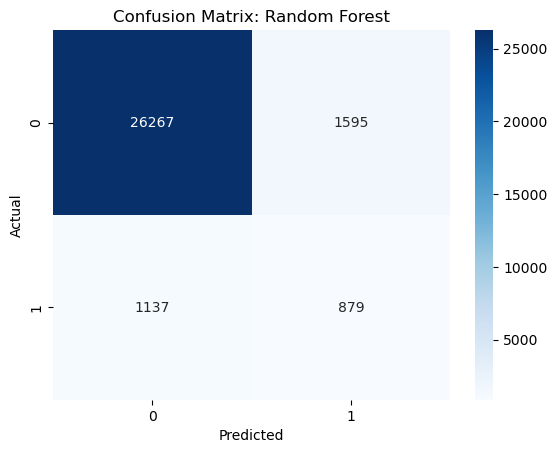


Classification Report: Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     27862
           1       0.22      0.74      0.33      2016

    accuracy                           0.80     29878
   macro avg       0.60      0.77      0.61     29878
weighted avg       0.93      0.80      0.85     29878



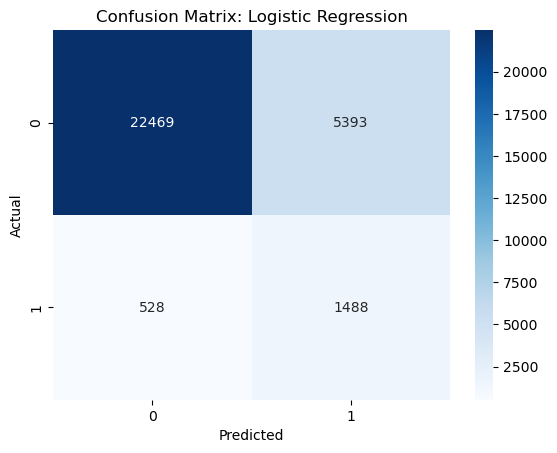

ROC AUC Score rf: 0.831
ROC AUC Score lr: 0.856


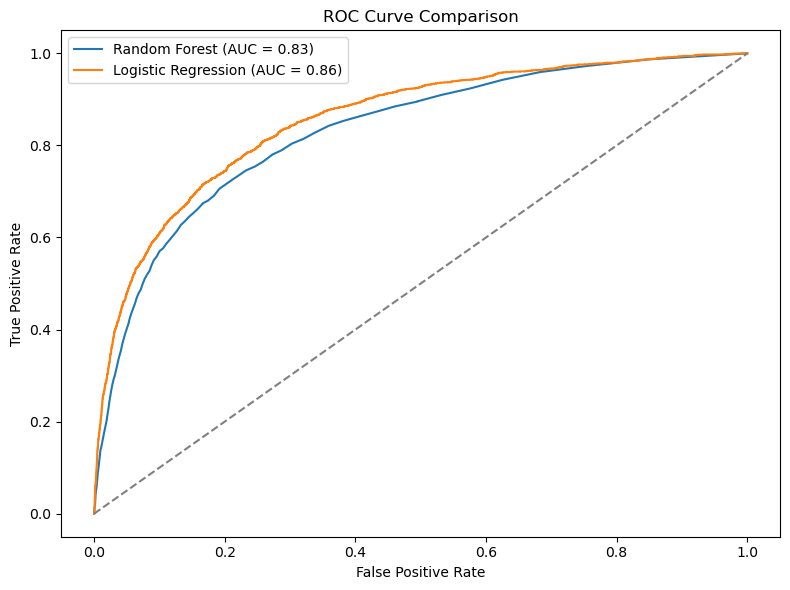

In [62]:
# Train Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Train Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)
lr_preds = lr_model.predict(X_test)
lr_probs = lr_model.predict_proba(X_test)[:, 1]

# Evaluation
for name, preds, probs in [('Random Forest', rf_preds, rf_probs), ('Logistic Regression', lr_preds, lr_probs)]:
    print(f"\nClassification Report: {name}")
    print(classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_lr = auc(fpr_lr, tpr_lr)

rfauc_score = roc_auc_score(y_test, rf_probs)
print(f"ROC AUC Score rf: {rfauc_score:.3f}")
lrauc_score = roc_auc_score(y_test, lr_probs)
print(f"ROC AUC Score lr: {lrauc_score:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


### Model Comparison: Logistic Regression vs. Random Forest

Logistic Regression and Random Forest take fundamentally different approaches to classification:

- **Logistic Regression** is a linear model that estimates the probability of default using a weighted sum of the input features. It is simple, interpretable, and fast, but may struggle to capture non-linear relationships or interactions between variables.

- **Random Forest** is an ensemble of decision trees that splits the feature space into multiple decision paths. It is better at capturing complex patterns and interactions, more robust to outliers, and provides feature importance for interpretability.

---

### Performance Summary
| Metric             | Random Forest  | Logistic Regression |
|--------------------|----------------|---------------------|
| Accuracy           | **91%**        | 80%                 |
| Precision (1)      | **36%**        | 22%                 |
| Recall (1)         | 44%            | **74%**             |
| F1 Score (1)       | **0.39**       | 0.33                |
| AUC                | 0.83           | **0.86**            |

> *Class `1` refers to defaulters (i.e., positive class). Metrics here focus on the model's ability to identify default risk accurately.*

---

### Interpretation

- **Recall:** Logistic Regression catches more of the actual defaulters (74% recall), but at the expense of precision – predicting many false positives.
- **Precision & F1:** Random Forest trades off some recall for better precision and a higher F1 score, indicating a more balanced and useful classifier.
- **AUC:** While Random Forest achieves higher accuracy and precision, Logistic Regression demonstrates better AUC, indicating better overall ranking of default risk by probability.

---

### Conclusion

Although Logistic Regression had a slightly higher AUC score, meaning it ranked defaulters more effectively by risk, Random Forest gave better results when making actual predictions. It had higher accuracy, precision, and F1 score, making it more useful in practice. Random Forest is also better at handling complex patterns and highlights the most important features, which adds value when analysing credit risk.

## 8. Threshold Tuning
By default, classifiers use a 0.5 threshold. We plot how precision, recall, and F1 change as the threshold moves from 0.1 to 0.9.


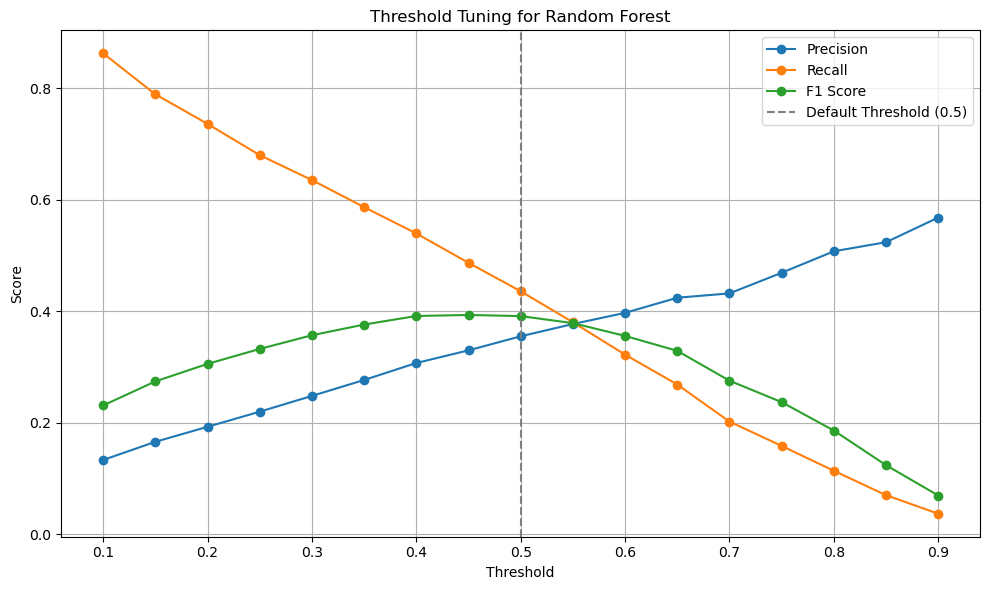

In [63]:
rf_test_probs = rf_model.predict_proba(X_test)[:, 1]

# Try thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.91, 0.05)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    preds = (rf_test_probs >= t).astype(int)
    precisions.append(precision_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning for Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 9. Final Predictions and Model Insights
In this section, predictions are generated on the test set using a thresholded version of the model's output probabilities. By adjusting the threshold, the balance between precision and recall can be tuned based on the specific goals of the analysis. Lower threshold would catch more defaulters but include more false positives (see confusion maatrix).

Key evaluation metrics are printed, and a confusion matrix is plotted to show how well the model performs under the chosen threshold.

In addition, feature importances are visualised to provide insight into which variables had the most influence on the model’s predictions.

Predictions saved to: output/random_forest_predictions.csv


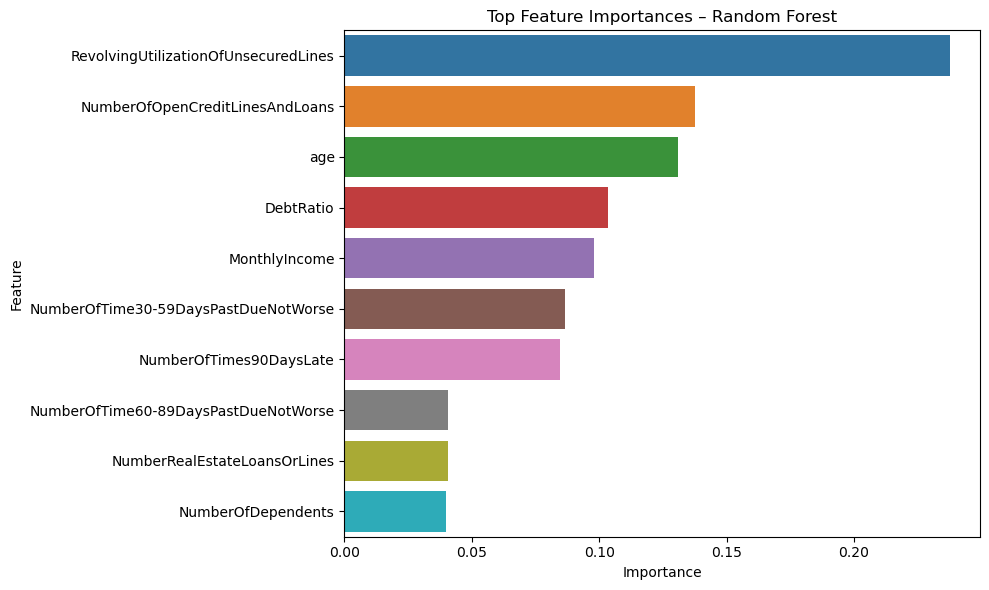


Classification Report (Threshold = 0.45):
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     27862
           1       0.33      0.50      0.40      2016

    accuracy                           0.90     29878
   macro avg       0.64      0.71      0.67     29878
weighted avg       0.92      0.90      0.91     29878



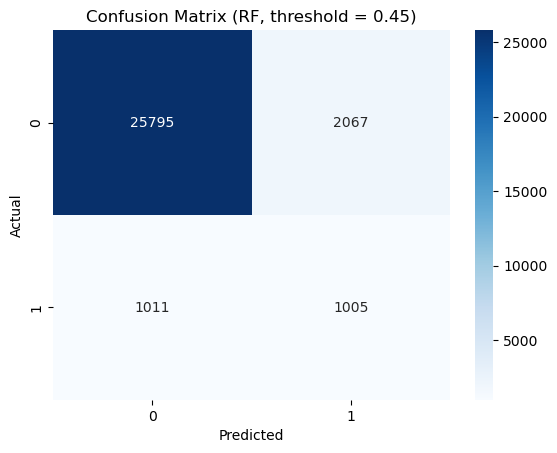

ROC AUC Score (untuned): 0.831


In [64]:
# Apply Threshold Tuning for the RF model only
tuned_threshold = 0.45
rf_test_preds = (rf_test_probs >= tuned_threshold).astype(int)

# Combine predictions with actual labels and probabilities
results_df = pd.DataFrame(X_test, columns=X.columns)
results_df['actual'] = y_test.values
results_df['predicted'] = rf_test_preds
results_df['predicted_proba'] = rf_test_probs

# Save predictions to file
results_df.to_csv("output/random_forest_predictions.csv", index=False)
print("Predictions saved to: output/random_forest_predictions.csv")

# Feature Importance Plot
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Top Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

print("\nClassification Report (Threshold = {:.2f}):".format(tuned_threshold))
print(classification_report(y_test, rf_test_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (RF, threshold = {:.2f})".format(tuned_threshold))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# AUC Score
auc_score = roc_auc_score(y_test, rf_test_probs)
print(f"ROC AUC Score (untuned): {auc_score:.3f}")

## Interpreting Threshold Tuning Through Predicted Probabilities

These three plots helps visualise how **threshold tuning affects the RF model’s classification behavior**, especially in an imbalanced setting like loan default prediction.

---

### 1. Predicted Probability by Actual Class (Log Y-axis)  
This plot shows the **distribution of model confidence** for each class (`default` vs `non-default`).  
- The log-scaled frequency helps highlight differences in lower-probability bins.  
- The **vertical threshold line** (eg 0.35) indicates where we split predictions into “default” vs “not default.”  
- The more **separation** between the two curves, the better the model is at distinguishing classes.

---

### 2. Predicted Probabilities for True Defaulters Only  
This zooms in on just the borrowers who **actually defaulted**.  
- Ideally, most of these should have predicted probabilities **above the threshold**, meaning we caught them.  
- If a large portion sits **below the line**, the model is missing real risk.  
This helps validate whether our **threshold is tuned well enough** to flag risk without being too conservative.

---

### 3. Class Proportions by Predicted Probability Bin  
This stacked bar plot shows how **default rates increase** as predicted probability increases.  
- It’s useful for “banding” risk: e.g., borrowers in the 0.7–0.8 range have a much higher default rate than those in the 0.2–0.3 range.  
- This view is **actionable** for decision-makers: you could define risk buckets, adjust pricing, or set different policies for each band.

---

### Why This Matters  
Threshold tuning is not just a technical adjustment — it's a **business decision lever**.  
These plots give us a visual toolkit to:
- Justify the selected threshold (eg 0.35)
- Understand **where** and **why** the model flags borrowers as high risk
- Align modeling choices with real-world risk appetite


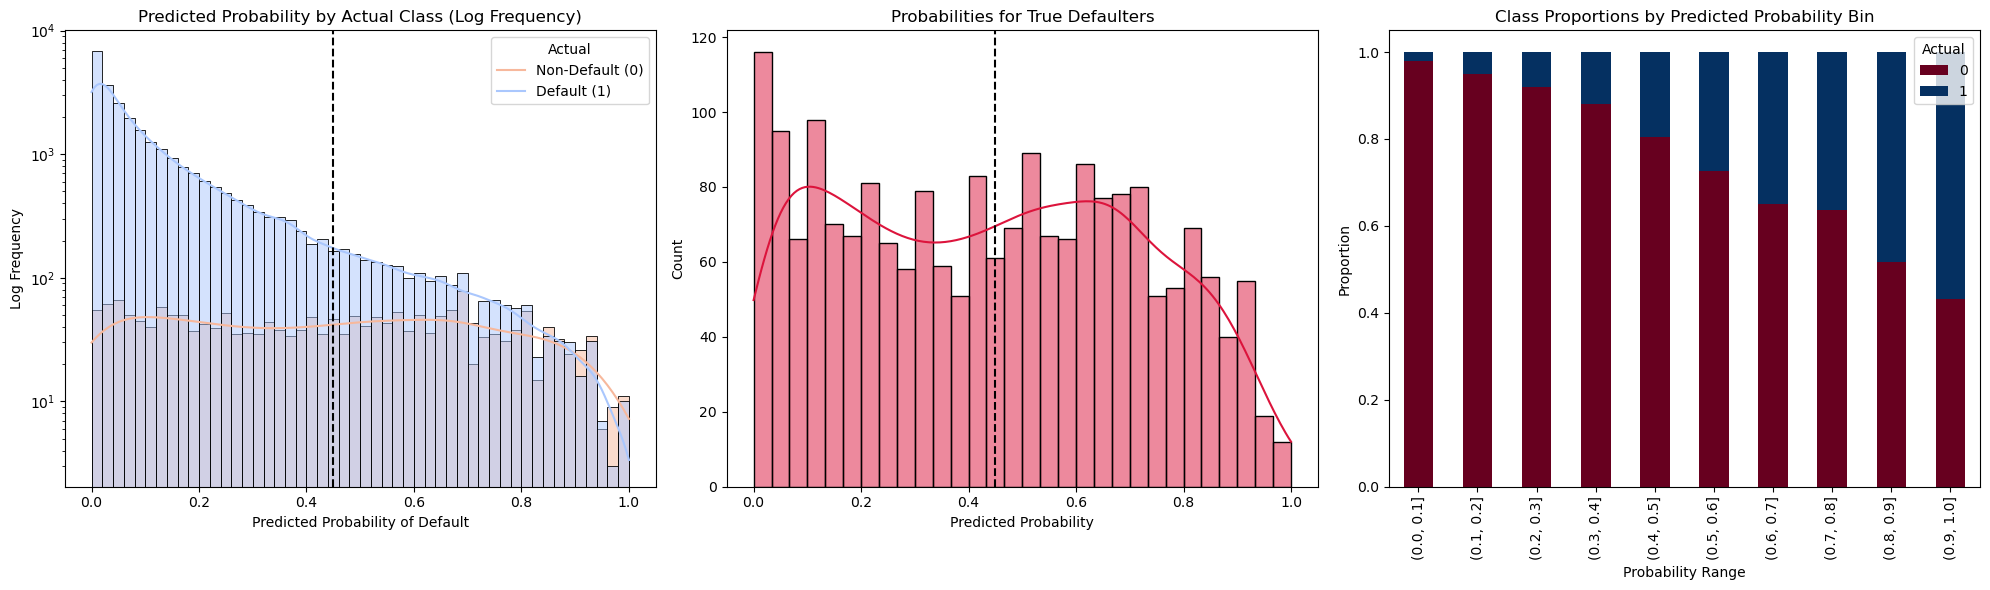

In [ ]:
# Define threshold line
threshold = tuned_threshold if 'tuned_threshold' in globals() else 0.35

# Bin probabilities into 0.1 ranges
results_df['proba_bin'] = pd.cut(results_df['predicted_proba'], bins=np.arange(0, 1.1, 0.1))

# Set up the 3-panel grid
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes = axes.flatten()

# 1. Predicted probability histogram by class (log-scaled y-axis)
sns.histplot(data=results_df, x='predicted_proba', hue='actual', kde=True,
             bins=50, palette='coolwarm', ax=axes[0])
axes[0].set_yscale('log')  # log frequency (y-axis)
axes[0].axvline(threshold, color='black', linestyle='--', label=f"Threshold = {threshold}")
axes[0].set_title("Predicted Probability by Actual Class (Log Frequency)")
axes[0].set_xlabel("Predicted Probability of Default")
axes[0].set_ylabel("Log Frequency")
axes[0].legend(title='Actual', labels=['Non-Default (0)', 'Default (1)'])


# 2. Defaulters only: their predicted probabilities 
sns.histplot(data=results_df[results_df['actual'] == 1], x='predicted_proba',
             bins=30, kde=True, color='crimson', ax=axes[1])
axes[1].axvline(threshold, color='black', linestyle='--')
axes[1].set_title("Probabilities for True Defaulters")
axes[1].set_xlabel("Predicted Probability")
axes[1].set_ylabel("Count")

# 3. Default rate by probability bin 
bin_dist = results_df.groupby('proba_bin')['actual'].value_counts(normalize=True).unstack().fillna(0)
bin_dist.plot(kind='bar', stacked=True, colormap='RdBu', ax=axes[2])
axes[2].set_title("Class Proportions by Predicted Probability Bin")
axes[2].set_xlabel("Probability Range")
axes[2].set_ylabel("Proportion")
axes[2].legend(title='Actual')

plt.tight_layout()
plt.show()
